# Results !

In [2]:
%reset -f
import json
import copy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from disaggregator import data, spatial
from disaggregator.config import get_config
from matplotlib.ticker import FuncFormatter
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

Import the data from the optimization notebook

In [3]:
with open("project_data/in/connections_O_10.json", 'r') as file:
    Connections = json.load(file)

In [4]:
with open("project_data/out/lengths.json", 'r') as file:
    pipesLengths = json.load(file)

In [5]:
with open("project_data/out/pipesDestination.json", 'r') as file:
    pipesDestination = pd.DataFrame.from_dict(json.load(file))

In [6]:
with open("project_data/out/finalPipes.json", 'r') as file:
    finalPipes = pd.DataFrame.from_dict(json.load(file))

Compute smol things

In [7]:
nuts = data.database_shapes()
nuts = nuts.drop(columns = ["id_ags", "gen", "fl_km2"])

pipesDestination = nuts.copy().drop(columns = ["geometry"])

pipesDestination["comingIn"] = np.zeros(401)
pipesDestination["outGoing"] = np.zeros(401)

for _, p in finalPipes.iterrows():
    pipesDestination.loc[p["origin"], "outGoing"] = 1
    pipesDestination.loc[p["destination"], "comingIn"] = 1

## CAPEX evolution

First, we will analyze the CAPEX. In the following graph we can see the total CAPEX, as well as the highest and lowest CAPEX out of all the n plants.

## Production as a function of blending

As the percentage of blending increases, the CAPEX will two, but how ?

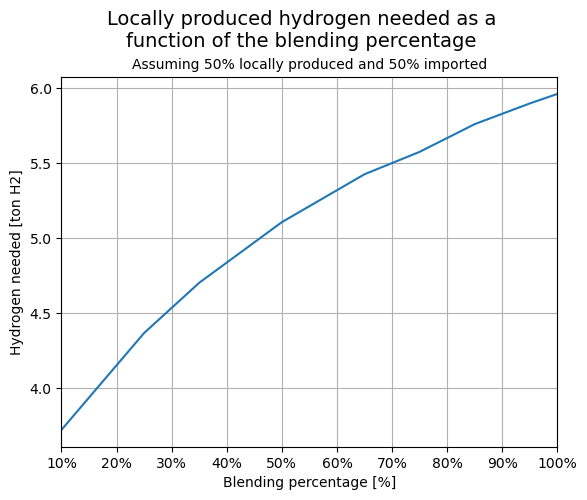

In [132]:
blendings = [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]

Y = []

for b in blendings:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json") as file:
        data = json.load(file)
        
        plantsCosts = data["specifications"]
        Y.append(max([sum(a) / 1e6 for a in plantsCosts if len(a) > 0]))

plt.plot(blendings, Y)

def percent_formatter(x, pos):
    return f"{x * 100:.0f}%"

plt.xlim([0.1, 1])
plt.xticks(np.linspace(0.1, 1, 10))

formatter = FuncFormatter(percent_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

plt.suptitle("Locally produced hydrogen needed as a\nfunction of the blending percentage", y=1.02, fontsize=14)
plt.title('Assuming 50% locally produced and 50% imported', fontsize=10)

plt.ylabel("Hydrogen needed [ton H2]")
plt.xlabel("Blending percentage [%]")

plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/production.png", transparent = True, dpi = 300, bbox_inches='tight')

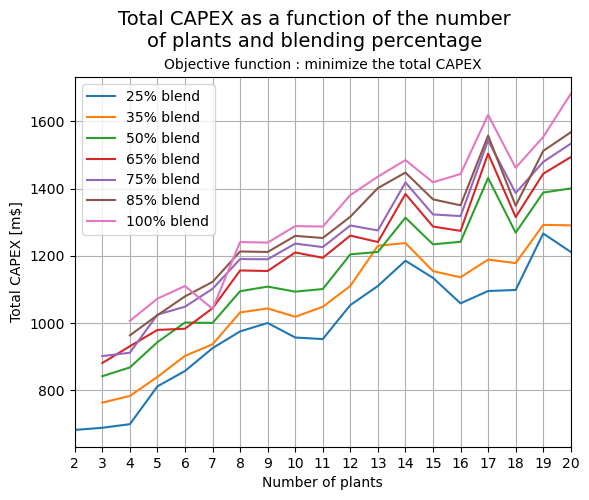

In [8]:
for b in [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 1]:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json") as file:
        data = json.load(file)
        
        plantsCosts = data["costs"]
        X = [len(i) for i in plantsCosts if len(i) > 0]
        plt.plot(X, [sum(a) / 1e6 for a in plantsCosts if len(a) > 0], label = str(int(100*b)) + "% blend")
        
plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, step=1))

plt.suptitle("Total CAPEX as a function of the number\nof plants and blending percentage", y=1.02, fontsize=14)
plt.title('Objective function : minimize the total CAPEX', fontsize=10)

plt.xlabel("Number of plants")
plt.ylabel("Total CAPEX [m$]")


plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/CAPEX_minLENGTH.png", transparent = True, dpi = 300, bbox_inches='tight')

## Staked plot to show specifications

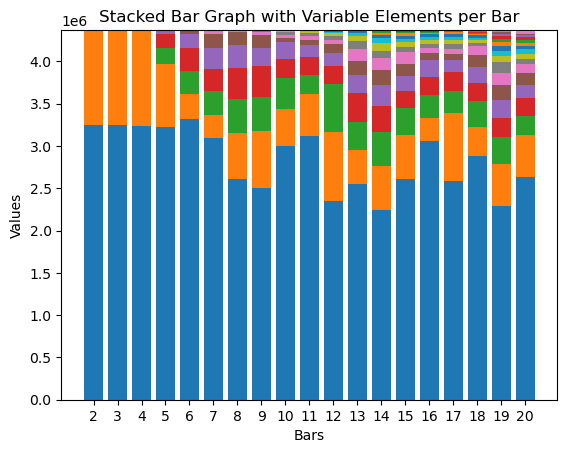

In [51]:
b = 0.25
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json") as file:
    data = json.load(file)
    
    plantsSpe = data["specifications"]

# Sort each sublist in data
data = [sorted(row, reverse=True) for row in plantsSpe]

num_bars = len(data)

# Create stacked bar plot
fig, ax = plt.subplots()

max_elements = max(len(row) for row in data)
bottom = np.zeros(num_bars)

for i in range(max_elements):
    values = [row[i] if i < len(row) else 0 for row in data]
    ax.bar(np.arange(num_bars), values, bottom=bottom)
    bottom += np.array(values)

plt.xticks(np.arange(num_bars), np.arange(2, num_bars + 2))

plt.xlabel('Bars')
plt.ylabel('Values')
plt.title('Stacked Bar Graph with Variable Elements per Bar')
plt.show()

## Number of districts served

In here, we can see the minimum and maximum number of districts the plants serve.

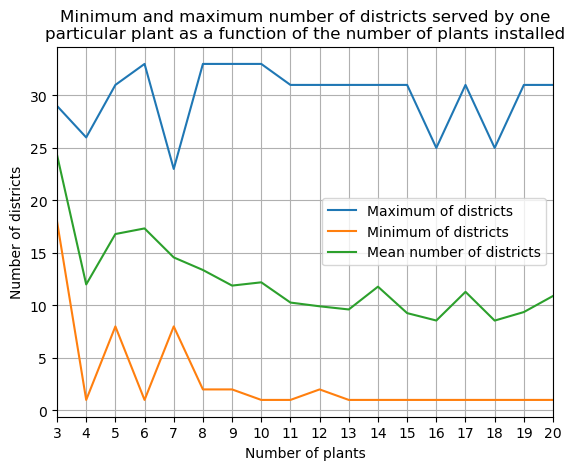

In [74]:
Ymin = []
Ymax = []
Ymean = []

plantsServing = []

b = 0.75
#for b in [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]:
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json") as file:
    data = json.load(file)
    plantsServing = data["servings"]

X = [len(a) for a in plantsServing if len(a) > 0]

for i in plantsServing:
    if (len(i)) == 0: continue
    
    Ymin.append(min([len(a) for a in i]))
    Ymax.append(max([len(a) for a in i]))
    Ymean.append(np.mean([len(a) for a in i]))

plt.plot(X, Ymax, label = "Maximum of districts")
plt.plot(X, Ymin, label = "Minimum of districts")
plt.plot(X, Ymean, label = "Mean number of districts")

plt.xlabel("Number of plants")
plt.ylabel("Number of districts")
plt.title("Minimum and maximum number of districts served by one\nparticular plant as a function of the number of plants installed")

plt.xlim([min(X), max(X)])
plt.xticks(np.arange(min(X), max(X) + 1, step=1))

plt.legend()
plt.grid()

# TODO : TOTAL NUMBER OF DISTRICTS TO GIVE
# TODO : NUMBER OF POP OR HH SERVED BY PLANT

# TODO : HOW THE CAPEX AND THE SUPPLY

## Total number of districts

Total number of districts served by n plants

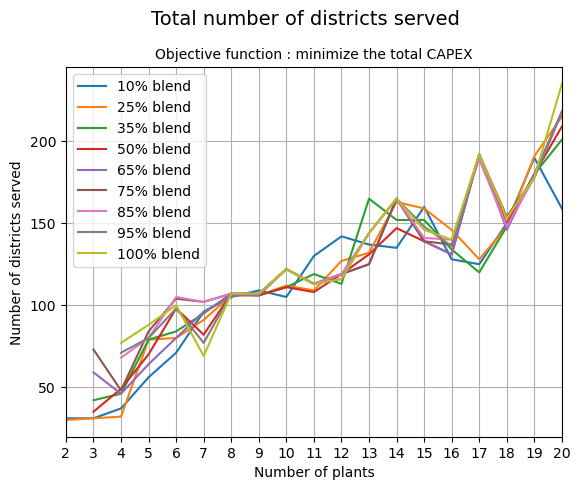

In [126]:
for b in [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json") as file:
        data = json.load(file)
        plantsServing = data["servings"]
    
    X = [len(a) for a in plantsServing if len(a) > 0]
    Y = []
    for a in plantsServing:
        if (len(a) == 0): continue
        
        Y.append(sum([len(i) for i in a]))
    
    plt.plot(X,Y, label = str(int(100*b)) + "% blend")

plt.suptitle("Total number of districts served", y=1, fontsize=14)
plt.title('Objective function : minimize the total CAPEX', fontsize=10)

plt.xlabel("Number of plants")
plt.ylabel("Number of districts served")

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, 1))

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/districts_minCAPEX.png", dpi = 300, transparent = True)

## Carbon emissions saved per dollar spent onelectrolysis plants

### Compute the industry CO2 emissions

In [9]:
from disaggregator import data
nuts = data.database_shapes()

files = ["amonia.json", "refineries.json", "steel.json"]

importData = []

for file in files:
    with open("project_data/in/" + file, 'r', encoding = "utf-8") as f:
        importData.append(json.load(f))

toDelete = []
points = []

i = 0
for dataE in importData:
    temp = []
    for element in dataE:
        if (element["Latitude"] == ""):
            toDelete.append(element)
            continue
          
        if (i == 1 and element["Product"] != "Crude"): # Keep only the crude production
            toDelete.append(element)
            continue
        
        if (i == 2 and element["Process"] == "Electric"): # Keep only high furnaces
            toDelete.append(element)
            continue
        
        element["geometry"] = [float(element["Longitude"]), float(element["Latitude"])]

        del element["Latitude"]
        del element["Longitude"]
        
        temp.append(Point(element["geometry"][0], element["geometry"][1]))
    
    i += 1
    points.append(temp)

for toD in toDelete: # Delete the industry that doesn't have coordinates or that doesn't consume H2
    for dataE in importData:
        if (not toD in dataE): continue
        dataE.remove(toD)

amonia = copy.deepcopy(importData[0])
refineries = copy.deepcopy(importData[1])
steel = copy.deepcopy(importData[2])

aPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[0]), crs = "EPSG:4326")
rPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[1]), crs = "EPSG:4326")
sPoints = gpd.GeoDataFrame(geometry = copy.deepcopy(points[2]), crs = "EPSG:4326")

aPoints = aPoints.to_crs("EPSG:25832")
rPoints = rPoints.to_crs("EPSG:25832")
sPoints = sPoints.to_crs("EPSG:25832")

# The production is in ton_product/yr so we must transform them into kgH2/d
# We have : ton -> kg (* 1000) , ratio H2/product (x / y) , year -> day (/ 365)

aPoints["consumption"] = [(int(a["Production"]) * 1000 * 176.14 / 1000 / 365) for a in amonia]          # In kgH2 / d
rPoints["consumption"] = [(int(r["Production"]) * 1000 * 1.02 / 227.69 / 365) for r in refineries]      # In kgH2 / d
sPoints["consumption"] = [(int(s["Production"]) * 1000 * 0.97 * 54.171367 / 1000 / 365) for s in steel] # In kgH2 / d

aPoints = gpd.sjoin(aPoints, nuts)
rPoints = gpd.sjoin(rPoints, nuts)
sPoints = gpd.sjoin(sPoints, nuts)

# Add the direct CO2 emissions - here we're taking a very limited approach since we don't consider the indirect emissions

aPoints["emissions"] = [(int(a["consumption"]) * 5457.46543) for _, a in aPoints.iterrows()]                         # In kgCO2 / d
rPoints["emissions"] = [(int(r["consumption"]) * 0.78 * 5457.46543) for _, r in rPoints.iterrows()]                  # In kgCO2 / d
sPoints["emissions"] = [(int(s["Production"]) * 1000 * 1.91 / 365) for s in steel]                                       # In kgCO2 / d

industryEmissions = sum([a["emissions"] for _, a in aPoints.iterrows()]) + sum([r["emissions"] for _, r in rPoints.iterrows()]) + sum([s["emissions"] for _, s in sPoints.iterrows()])

In [10]:
# =========== Household sizes ===========

from disaggregator import data

df = data.database_get('spatial', table_id=14, force_update = False)
df = df.assign(nuts3=lambda x: x.id_region.map(data.dict_region_code()),
                    hh_size=lambda x: x.internal_id.str[0].astype(int)) .loc[lambda x: x.hh_size != 0] .pivot_table(values='value', index='nuts3', columns='hh_size',aggfunc='sum')

cfg = get_config()
year = cfg['base_year']
gas_nuts0 = spatial.gas_consumption_HH(year=year)

hh_size = df.copy()

hh_size[3] = hh_size[3] + hh_size[4] + hh_size[5]
hh_size.drop(columns = [4, 5], inplace = True)

HH_dict = {
    1 : '1FH',
    2 : 'TH',
    3 : 'MFH',
    6 : 'MSB'
}

hh_size.rename(columns = HH_dict, inplace = True)

hh_size.reset_index(inplace=True)
hh_size.rename(columns={'index': 'nuts3'}, inplace=True)


# Melting the DataFrame
melted_df = hh_size.melt(id_vars=['nuts3'], var_name='building_type', value_name='value')
melted_df.sort_values(by='nuts3', inplace=True)
melted_df.reset_index(drop=True, inplace=True)

norm_HH = melted_df.copy()
norm_HH["value"] = melted_df["value"] / melted_df["value"].values.sum()
norm_HH["value"] *= gas_nuts0['Cooking']

# =========== Population ===========

# Define multiplication factors
multipliers = {
    '1FH': 1,
    'TH':  1,
    'MFH': 4,
    'MSB': 20
}

pop_df = melted_df.copy()
# Apply multiplications based on building_type
pop_df['multiplier'] = melted_df['building_type'].map(multipliers)
pop_df['value'] = melted_df['value'] * pop_df['multiplier']
pop_df.drop(columns = ["multiplier"], inplace=True)

norm_pop = pop_df.copy()
norm_pop["value"] = pop_df["value"] / pop_df["value"].sum()
norm_pop["value"] *= gas_nuts0['HotWater']

# =========== Living space ===========

df_living_space = spatial.living_space(aggregate=False, year=2018,
                          internal_id=[None, None, 11, 1]).drop(columns = ['heating_system', 'non_empty_building']).replace()

buildingDict = {'2FH' : 'TH',
                'MFH_03_06': 'MFH',
                'MFH_07_12': 'MSB',
                'MFH_13_99': 'MSB'}

df_living_space.replace(buildingDict, inplace=True)

df_living_space = df_living_space.groupby(['nuts3', 'building_type']).mean()

# uniform non-matching vintage sections
new_m2_vintages = {'A_<1900':     'A_<1948',
                   'B_1900-1945': 'A_<1948',
                   'C_1946-1960': 'B_1949-1968',
                   'D_1961-1970': 'B_1949-1968',
                   'E_1971-1980': 'C_1969-1985',
                   'F_1981-1985': 'C_1969-1985',
                   'G_1986-1995': 'D_1986-1995',
                   'H_1996-2000': 'E_1996-2000',
                   'I_2001-2005': 'F_>2000',
                   'J_2006-2011': 'F_>2000',
                   'K_2012': 'F_>2000',
                   'L_2013': 'F_>2000',
                   'M_2014': 'F_>2000',
                   'N_2015': 'F_>2000',
                   'O_2016': 'F_>2000',
                   'P_2017': 'F_>2000',
                   'Q_2018': 'F_>2000',
                   'R_2019': 'F_>2000'}
new_dem_vintages = {'A_<1859':     'A_<1948',
                    'B_1860-1918': 'A_<1948',
                    'C_1919-1948': 'A_<1948',
                    'D_1949-1957': 'B_1949-1968',
                    'E_1958-1968': 'B_1949-1968',
                    'F_1969-1978': 'C_1969-1985',
                    'G_1979-1983': 'C_1969-1985',
                    'H_1984-1994': 'D_1986-1995',
                    'I_1995-2001': 'E_1996-2000',
                    'J_2002-2009': 'F_>2000'}

# Status Quo buildings
df1 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 1])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class != 'A_<1948'])

# df2 = refurbished buildings
df2 = (spatial.heat_demand_buildings(table_id=56, year=2018,
                             internal_id=[None, None, 1, 2])
       .replace(dict(vintage_class=new_dem_vintages))
       .loc[lambda x: x.vintage_class == 'A_<1948'])
df_heat_dem = pd.concat([df1, df2])

# FOR HEATING WE HAVE THE FOLLOWING : ['1FH', 'TH', 'MFH', 'MSB']
# FOR LIVING SPACE WE HAVE : ['1FH', '2FH', 'MFH_03_06', 'MFH_07_12', 'MFH_13_99']

df_heat = df_heat_dem
df_heat['building_type'] = df_heat_dem['building_type'].replace(buildingDict, regex=True)

df_heat = df_heat.groupby(['nuts3', 'building_type']).sum() / 1e3 # kWh -> MWh

df_heating_gas = df_heat.copy()

df_heating_gas['value'] = 2.14 * df_living_space['value'].multiply(df_heat['value'], fill_value=0)
df_heating_gas.reset_index(drop=False, inplace=True)
# FOR HEATING WE HAVE THE FOLLOWING : ['1FH', 'TH', 'MFH', 'MSB']
# FOR LIVING SPACE WE HAVE : ['1FH', '2FH', 'MFH_03_06', 'MFH_07_12', 'MFH_13_99']

# =========== PUTTING IT ALL TOGETHER ===========

merged_df = pd.merge(norm_HH, norm_pop, on=['nuts3', 'building_type'], suffixes=(' HH', ' pop'))
merged_df = pd.merge(merged_df, df_heating_gas, on=['nuts3', 'building_type'])

merged_df['value'] = merged_df['value pop'] + merged_df['value HH'] + merged_df['value']
merged_df.drop(columns = ["value HH", "value pop"], inplace=True)

# =========== Filter the buildings we wish to have ===========

gasMultipliers = {
    '1FH' : 0,
    'TH'  : 0,
    'MFH' : 1,
    'MSB' : 1
}

gasDemand1FH = merged_df.loc[merged_df["building_type"] == "1FH"].copy()
gasDemandTH  = merged_df.loc[merged_df["building_type"] ==  "TH"].copy()
gasDemandMFH = merged_df.loc[merged_df["building_type"] == "MFH"].copy()
gasDemandMSB = merged_df.loc[merged_df["building_type"] == "MSB"].copy()

gasDemand1FH['value'] = gasMultipliers["1FH"] * merged_df.loc[merged_df["building_type"] == "1FH"]['value']
gasDemandTH['value']  = gasMultipliers["TH"]  * merged_df.loc[merged_df["building_type"] ==  "TH"]['value']
gasDemandMFH['value'] = gasMultipliers["MFH"] * merged_df.loc[merged_df["building_type"] == "MFH"]['value']
gasDemandMSB['value'] = gasMultipliers["MSB"] * merged_df.loc[merged_df["building_type"] == "MSB"]['value']

gasDemand1FH.fillna(0, inplace = True)
gasDemandTH.fillna(0, inplace = True)
gasDemandMFH.fillna(0, inplace = True)
gasDemandMSB.fillna(0, inplace = True)

gasDemand = pd.concat([gasDemand1FH, gasDemandTH, gasDemandMFH, gasDemandMSB], ignore_index = True)

gasDemandGrouped = gasDemand.groupby('nuts3')['value'].sum().reset_index()
gasDemandGrouped.set_index('nuts3', inplace = True)

# =========== Group the demand into one single dataframe ===========

gasDemand = pd.concat([gasDemand1FH, gasDemandTH, gasDemandMFH, gasDemandMSB], ignore_index = True)

gasDemandGrouped = gasDemand.groupby('nuts3')['value'].sum().reset_index()
gasDemandGrouped.set_index('nuts3', inplace = True)

In [11]:
# =========== Function to group the demand ===========

def computeHydrogenDemand(b, etaH2 = 0.83, etaCH4 = 0.94): # Where b between 0-1 is the percentage of blending
    hydrogenDemand = gasDemandGrouped * 1000 / 365 # kWh/d

    HVch4 = 14.583 # kWh / kgCH4
    HVh2  = 33.33  # kWh / kgH2

    #etaH2  = 0.83 # https://ieeexplore.ieee.org/abstract/document/7275758
    
    
    hydrogenDemand = hydrogenDemand / ( ( (1 - b) / b) * HVch4 + HVh2)

    hydrogenDemand["value"] = pipesDestination["comingIn"] * hydrogenDemand["value"]

    for index, row in aPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    for index, row in rPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    for index, row in sPoints.iterrows():
        hydrogenDemand.loc[row["index_right"], "value"] += row["consumption"]

    if ("XX" in list(hydrogenDemand.index)): hydrogenDemand.drop("XX", inplace = True)

    threshold = 0.5 * hydrogenDemand["value"].sum()

    centroidData = np.column_stack((nuts.centroid.x, nuts.centroid.y, hydrogenDemand["value"].values)) # Coords of the points

    b = 1 - b
    
    if (b == 0) : co2Emissions = 2.74319011 * (hydrogenDemand / (etaCH4 * HVch4)).sum() # Full H2 no CH4
    else:         co2Emissions = 2.74319011 * (hydrogenDemand / ( (etaCH4 * HVch4 + (1 - b) / b) * HVh2 * etaH2)).sum()
    
    return threshold, hydrogenDemand, centroidData, co2Emissions

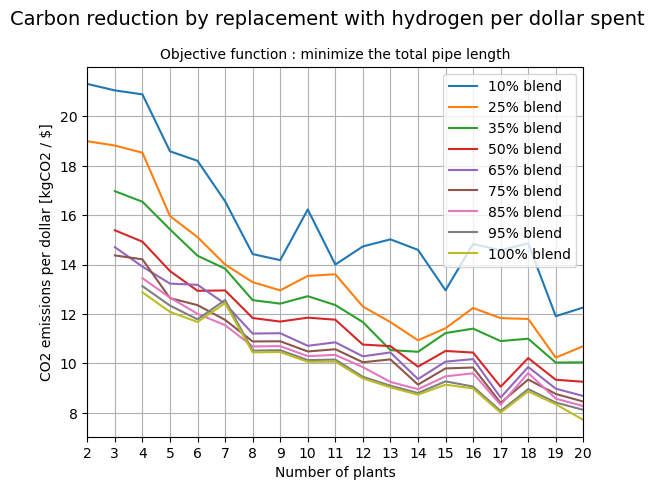

In [12]:
# Compute how much carbon is saved per dollar
blendings = [0.1, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 1]
for b in blendings:
    _, _, _, residentialEmissions = computeHydrogenDemand(b)
    totEm = residentialEmissions + industryEmissions
    
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
        data = json.load(file)
        
        plantsCosts = data["costs"]
        X = [len(i) for i in plantsCosts]
        Y = [totEm / c for c in [sum(a) for a in plantsCosts]]
        plt.plot(X, Y, label = str(int(100*b)) + "% blend")

plt.suptitle("Carbon reduction by replacement with hydrogen per dollar spent", y=1, fontsize=14)
plt.title('Objective function : minimize the total pipe length', fontsize=10)
plt.xlabel("Number of plants")
plt.ylabel("CO2 emissions per dollar [kgCO2 / $]")

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, step=1))

plt.legend()
plt.grid()
plt.show()  # Add this line outside the loop

#plt.savefig("project_data/out/Images/CO2_minLENGTH.png", transparent = True, dpi = 300)

## Population served

In [148]:
with open("project_data/out/pipesDestination.json", 'r') as file:
    pipesDestination = pd.DataFrame().from_dict(json.load(file))
    pipesDestination.drop('XX', inplace = True)

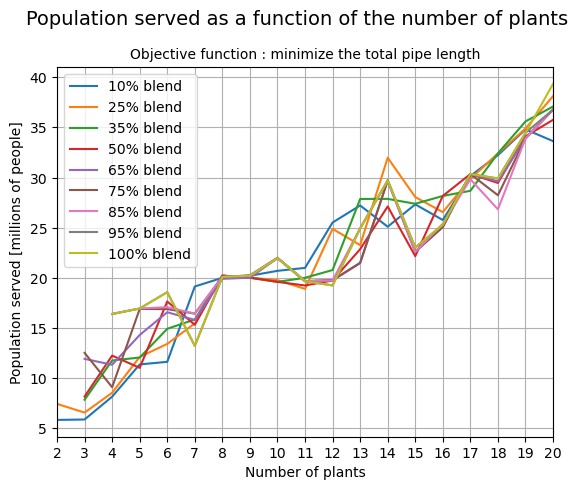

In [130]:
gasMultipliers = {
    '1FH' : 0,
    'TH'  : 0,
    'MFH' : 1,
    'MSB' : 1
}

p = pop_df.copy()
p['multiplier'] = p['building_type'].map(gasMultipliers)
p['value'] = p['value'] * p['multiplier']
p.drop(columns = ["multiplier"], inplace=True)
p = p.groupby('nuts3').sum()

totPopulation = (p['value'] * pipesDestination['comingIn']).sum()
totPopulation / 1e6

for b in blendings:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
        data = json.load(file)
        plantsServings = data["servings"]

    X = []
    Y = []

    for cluster in plantsServings: # For plant of the cluster each cluster
        if (len(cluster) == 0): continue
        
        pop = 0
        X.append(len(cluster))
        for i in cluster:          # For each destination of each plant
            for a in i:
                pop += p.loc[a, 'value']

        Y.append(pop / 1e6)

    plt.plot(X, Y, label = str(int(100*b)) + "% blend")

plt.suptitle("Population served as a function of the number of plants", y=1, fontsize=14)
plt.title('Objective function : minimize the total CAPEX', fontsize=10)

plt.xlabel('Number of plants')
plt.ylabel('Population served [millions of people]')

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, 1))

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/pop_minCAPEX.png", dpi = 300, transparent = True)

## Distance from plants

In this following graph we can see the mean, standard deviation, minimum and maximum distance for each of the clusters.

In [106]:
def getDistancePath(path): # Returns the length of a path by adding the length between all the points inside of a path
    distance = 0
    
    for i in range(len(path) - 1):
        distance += pipesLengths[path[i]][path[i + 1]]
    
    return distance

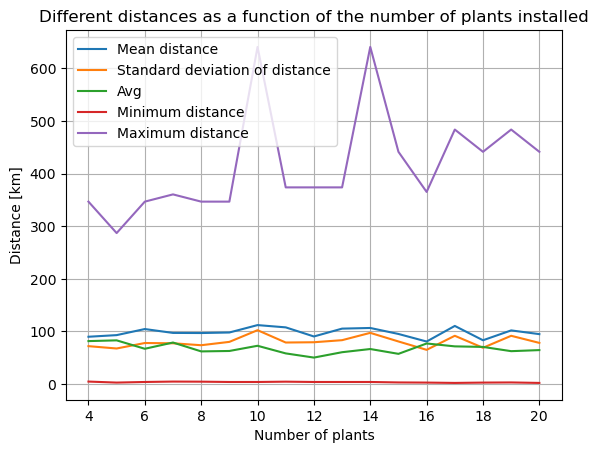

In [113]:
b = 1
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
    currentCase = json.load(file)
    
    plantsServings = currentCase["servings"]
    plantsSpecifications = currentCase["specifications"]
    plantsLocations = currentCase["locations"]

totDistance = []

meanDistance = []
stdDistance = []

avgDistance = []

minDistance = []
maxDistance = []

X = [len(a) for a in plantsServings if len(a) > 0]

for i, cluster in enumerate(plantsServings): # For each number of plants n : 2 -> 20
    if (len(cluster) == 0): continue
    
    _, hydrogenDemand, _, _ = computeHydrogenDemand(b)
    
    mn  = 0
    avg = 0
    
    lengths = [] # Lenghts
    demd = []    # Demand
    
    for j, servs in enumerate(cluster): # For each plant in the n plants
        for serv in servs: # Add the length of all the places it serves
            lengths.append(getDistancePath(Connections[plantsLocations[i][j]][serv]))
            demd.append(hydrogenDemand.loc[serv]['value'])
    
    totDistance.append(sum(lengths))
    
    lengths = np.array(lengths)
    
    meanDistance.append(np.mean(lengths))
    stdDistance.append(np.std(lengths))
    
    avgDistance.append(np.average(lengths, weights = demd)) # Compute the avg by weighting with the H2 demand

    minDistance.append(min(lengths))
    maxDistance.append(max(lengths))
    
plt.plot(X, meanDistance, label = "Mean distance")
plt.plot(X, stdDistance, label = "Standard deviation of distance")

plt.plot(X, avgDistance, label = "Avg")

plt.plot(X, minDistance, label = "Minimum distance")
plt.plot(X, maxDistance, label = "Maximum distance")

plt.xlabel("Number of plants")
plt.ylabel("Distance [km]")
plt.title("Different distances as a function of the number of plants installed")

plt.legend()
plt.grid()
plt.show()

## Total length

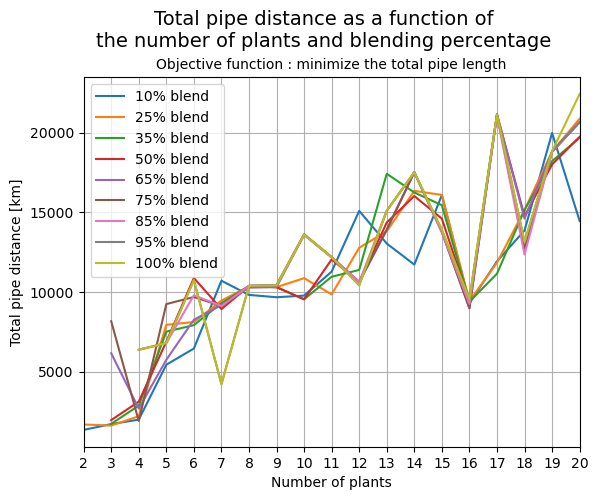

In [141]:
for b in blendings:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minLENGTH.json", 'r') as file:
        currentCase = json.load(file)

        plantsServings = currentCase["servings"]
        plantsSpecifications = currentCase["specifications"]
        plantsLocations = currentCase["locations"]

    totDistance = []

    X = [len(a) for a in plantsServings if len(a) > 0]

    for i, cluster in enumerate(plantsServings): # For each number of plants n : 2 -> 20
        if (len(cluster) == 0): continue

        lengths = [] # Lenghts
        
        for j, servs in enumerate(cluster): # For each plant in the n plants
            for serv in servs: # Add the length of all the places it serves
                lengths.append(getDistancePath(Connections[plantsLocations[i][j]][serv]))
                demd.append(hydrogenDemand.loc[serv]['value'])

        totDistance.append(sum(lengths))

    plt.plot(X, totDistance, label = str(int(100*b)) + "% blend")

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, 1))

plt.suptitle("Total pipe distance as a function of\nthe number of plants and blending percentage", y=1.02, fontsize=14)
plt.title('Objective function : minimize the total pipe length', fontsize=10)

plt.xlabel("Number of plants")
plt.ylabel("Total pipe distance [km]")

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/length_minLENGTH.png", dpi = 300, transparent = True, bbox_inches = 'tight')

## Compute the potential of the plants

threshold (produced locally) / total demand

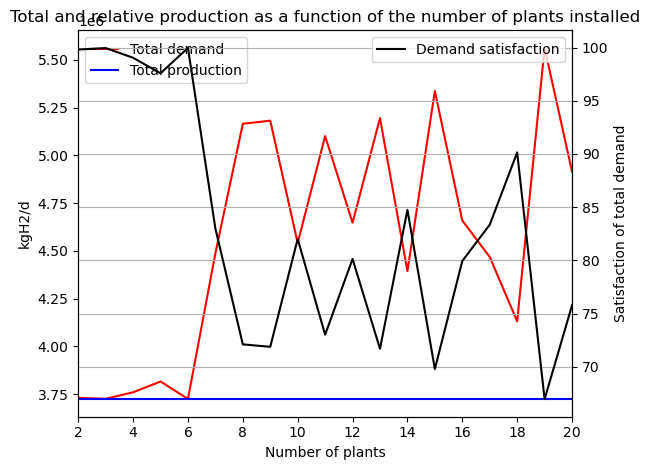

In [154]:
b = 0.1
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
    currentCase = json.load(file)
    
    plantsServings = currentCase["servings"]
    plantsSpecifications = currentCase["specifications"]

X = [len(a) for a in plantsServings if len(a) > 0]

totProduction = []
for plants in plantsSpecifications:
    if (len(plants) == 0): continue
    totProduction.append(sum([a for a in plants]))

threshold, hydrogenDemand, _, _ = computeHydrogenDemand(b)

totalDemand = []

for servs in plantsServings:
    if(len(servs) == 0): continue
    
    totalDemand.append(0)
    
    for serv in servs:
        totalDemand[-1] += sum([hydrogenDemand.loc[a]['value'] for a in serv])

fig, ax1 = plt.subplots()

ax1.plot(X, totalDemand, color = "r", label = "Total demand")
ax1.plot(X, totProduction, color = "b", label = "Total production")

ax1.set_title("Total and relative production as a function of the number of plants installed")
ax1.set_xlabel('Number of plants')
ax1.set_ylabel('kgH2/d')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

ax2.plot(X, 100 * np.divide(np.array(totProduction), np.array(totalDemand)), color="k", label = "Demand satisfaction")

ax2.set_ylabel('Satisfaction of total demand', color="k")  # we already handled the x-label with ax1

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xlim([min(X), max(X)])

plt.grid()
ax1.legend()
ax2.legend()

plt.show()

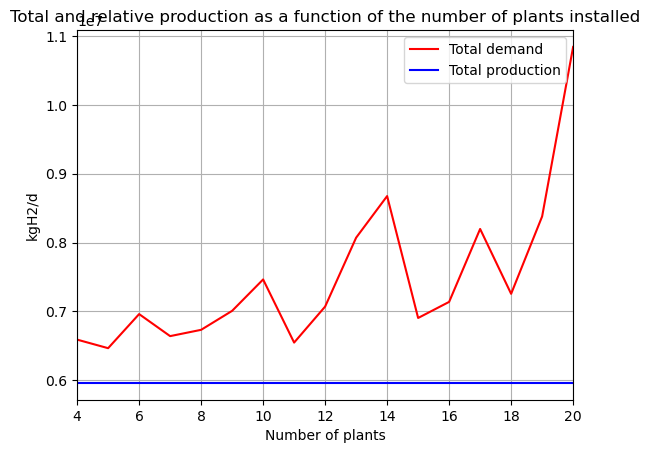

In [157]:
b = 1
with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minCAPEX.json", 'r') as file:
    currentCase = json.load(file)
    
    plantsServings = currentCase["servings"]
    plantsSpecifications = currentCase["specifications"]

X = [len(a) for a in plantsServings if len(a) > 0]

totProduction = []
for plants in plantsSpecifications:
    if (len(plants) == 0): continue
    totProduction.append(sum([a for a in plants]))

threshold, hydrogenDemand, _, _ = computeHydrogenDemand(b)

totalDemand = []

for servs in plantsServings:
    if(len(servs) == 0): continue
    
    totalDemand.append(0)
    
    for serv in servs:
        totalDemand[-1] += sum([hydrogenDemand.loc[a]['value'] for a in serv])

plt.plot(X, totalDemand, color = "r", label = "Total demand")
plt.plot(X, totProduction, color = "b", label = "Total production")

plt.title("Total and relative production as a function of the number of plants installed")
plt.xlabel('Number of plants')
plt.ylabel('kgH2/d')

plt.xlim([min(X), max(X)])

plt.legend()
plt.grid()
plt.show()

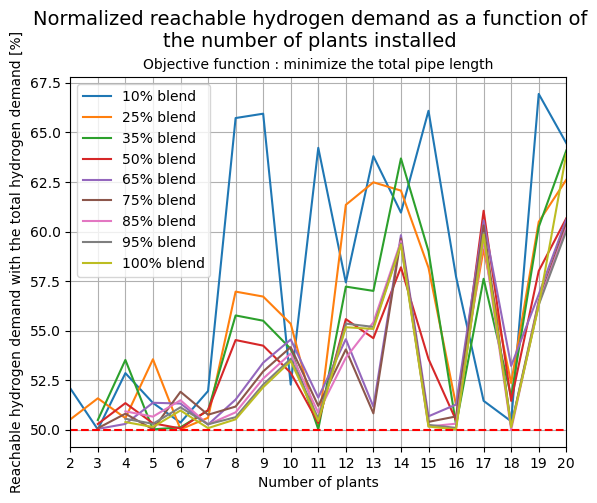

In [13]:
for b in blendings:
    with open("project_data/out/reducedDemand/optimalPlaces_reduced" + str(b) + "_minLENGTH.json", 'r') as file:
        currentCase = json.load(file)

        plantsServings = currentCase["servings"]
        plantsSpecifications = currentCase["specifications"]

    X = [len(a) for a in plantsServings if len(a) > 0]

    totProduction = []
    for plants in plantsSpecifications:
        if (len(plants) == 0): continue
        totProduction.append(sum([a for a in plants]))

    threshold, hydrogenDemand, _, _ = computeHydrogenDemand(b)
    
    maxDemand = hydrogenDemand.sum()
    
    totalDemand = []
    for servs in plantsServings:
        places = []
        if(len(servs) == 0): continue

        totalDemand.append(0)

        for serv in servs:
            totalDemand[-1] += sum([hydrogenDemand.loc[a]['value'] for a in serv])
        
        totalDemand[-1] = 100 * totalDemand[-1] / maxDemand
    
    plt.plot(X, totalDemand, label = str(int(100*b)) + "% blend")

plt.plot(np.arange(2, 21, 1), 50 * np.ones(19), 'r--')

plt.suptitle("Normalized reachable hydrogen demand as a function of\nthe number of plants installed", y=1.02, fontsize=14)
plt.title('Objective function : minimize the total pipe length', fontsize=10)

plt.xlabel('Number of plants')
plt.ylabel('Reachable hydrogen demand with the total hydrogen demand [%]')

plt.xlim([2, 20])
plt.xticks(np.arange(2, 21, 1))

plt.legend()
plt.grid()
plt.show()

#plt.savefig("project_data/out/Images/relativeProduction_minCAPEX.png", dpi = 300, transparent = True, bbox_inches = 'tight')